Let me explain what we have done in the following code cells. We created a BraTSSegDataset class, whose role was to get images, and masks corresponding to them and covert them from (128,128,128,4) to (4,128,128,128) i.e. channel shoould come first for pytorch to work. Channels are the types of tumors namely 0 : Background , (1,2,3) : Tumor. So images in BraTS dataset are of 3d form 128*128*128 with 4 channels.  

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class BraTSSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.masks  = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images) 

    def __getitem__(self, idx):
        img_path  = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir,  self.masks[idx])

        # Load image
        img = np.load(img_path)                 # (128,128,128,4)
        img = np.transpose(img, (3,0,1,2))      # (4,128,128,128)
        img = img.astype(np.float32)

        # Load mask
        mask = np.load(mask_path)               # (128,128,128,4)
        mask = np.any(mask[..., 1:], axis=-1).astype(np.float32)
        #mask = np.transpose(mask, (3,0,1,2))    # (4,128,128,128)
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)

        return torch.tensor(img), torch.tensor(mask)


In the below code cell's output you can see unique values as 0 and 1 where 0 means no tumor and 1 indicates presence of tumor. We have done this because if we would have gone with multiclass clssification then it would have required high gpu and memory.

In [17]:
dataset = BraTSSegDataset(
    image_dir=r"D:\BraTS_Data\train\images",
    mask_dir=r"D:\BraTS_Data\train\masks"
)

img, mask = dataset[0]
print(img.shape, mask.shape)
print(torch.unique(mask))


NameError: name 'BraTSSegDataset' is not defined

In [3]:
img.shape
mask.shape


torch.Size([1, 128, 128, 128])

In [4]:
#Just to check
for i in [0, 5, 10, 20]:
    _, m = dataset[i]
    print(f"Sample {i} unique mask values:", torch.unique(m))


Sample 0 unique mask values: tensor([0., 1.])
Sample 5 unique mask values: tensor([0., 1.])
Sample 10 unique mask values: tensor([0., 1.])
Sample 20 unique mask values: tensor([0., 1.])


In [5]:
import numpy as np

for i in [0, 5, 10]:
    mask = np.load(f"D:/BraTS_Data/train/masks/mask_{i}.npy")

    print(f"\nSample {i}")
    for c in range(4):
        print(f" Channel {c} nonzero voxels:",
              np.count_nonzero(mask[..., c]))

    bg = np.sum(np.all(mask == 0, axis=-1))
    print(" Background voxels:", bg)


Sample 0
 Channel 0 nonzero voxels: 2056568
 Channel 1 nonzero voxels: 1717
 Channel 2 nonzero voxels: 32773
 Channel 3 nonzero voxels: 6094
 Background voxels: 0

Sample 5
 Channel 0 nonzero voxels: 1850230
 Channel 1 nonzero voxels: 23494
 Channel 2 nonzero voxels: 141256
 Channel 3 nonzero voxels: 82172
 Background voxels: 0

Sample 10
 Channel 0 nonzero voxels: 1878585
 Channel 1 nonzero voxels: 19940
 Channel 2 nonzero voxels: 155513
 Channel 3 nonzero voxels: 43114
 Background voxels: 0


After seeing the above output we initially got cinfused that how can background  voxels come to be 0 but thhen we got to know that in the dataset background voxel is not denoted by all channels 0 it is denoted by making value of channel-0 as 0. So the coding logic that voxels where values of all channels is 0 is not the right approach to detect background voxel. Therefore, we further proceeded with binary classification that if any one of the values of later 3 channels is 1 then it is a tumor otherwise it is background that is why in cell no. 19 np.any was used. Also, I know that tumor_mask shape should be (1,128,128,128) where 1 will be detecting binary decision, but this is a numpy array that's why you are seeing (128,128,128). When it will get converted to pytorch the shape will become (1,128,128,128).

In [6]:
bg = np.count_nonzero(mask[..., 0] == 1)
print("Background voxels:", bg)


Background voxels: 1878585


In [7]:
tumor_mask = np.any(mask[..., 1:], axis=-1).astype(np.float32)
print("tumor_mask shape:", tumor_mask.shape)
print("Unique values:", np.unique(tumor_mask))

tumor_mask shape: (128, 128, 128)
Unique values: [0. 1.]


In [8]:
background = np.all(mask[..., 1:] == 0, axis=-1)

print("Background + tumor == volume:",
      np.sum(background) + np.sum(tumor_mask),
      "==",
      np.prod(tumor_mask.shape))

Background + tumor == volume: 2097152.0 == 2097152


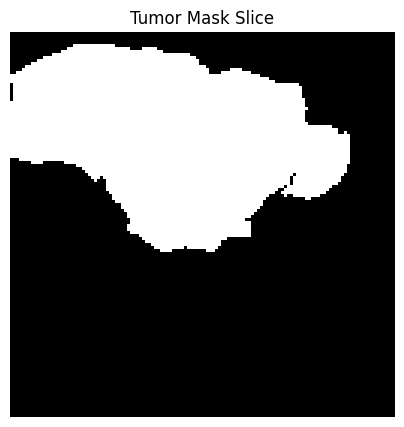

In [9]:
#just a test
import matplotlib.pyplot as plt

z = 64  # middle slice
plt.figure(figsize=(5,5))
plt.imshow(tumor_mask[:, :, z], cmap="gray")
plt.title("Tumor Mask Slice")
plt.axis("off")
plt.show()


Now we will proceed with Dataloader. Work of dataloader is to load files and shuffle them for effecient training. Batch size is kept as 1 because of the system specifications.

In [22]:
#Proceeding with dataloader
import torch
import torch.nn as nn
train_dataset = BraTSSegDataset(
    image_dir=r"D:\BraTS_Data\train\images",
    mask_dir=r"D:\BraTS_Data\train\masks"
)

val_dataset = BraTSSegDataset(
    image_dir=r"D:\BraTS_Data\val\images",
    mask_dir=r"D:\BraTS_Data\val\masks"
)

test_dataset = BraTSSegDataset(
    image_dir=r"D:\BraTS_Data\test\images",
    mask_dir=r"D:\BraTS_Data\test\masks"
)

In [23]:
from torch.utils.data import DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,   #initially num_workers was set as 2 but the process didnt run in the later cell and exited unexpectedly, thats why num_workers was made 0   
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [12]:
#checking dataloader's functionality before proceeding 
imgs, tumor_mask = next(iter(train_loader))

print("Image shape:", imgs.shape)
print("Mask shape :", tumor_mask.shape)
print("Mask values:", torch.unique(tumor_mask))

e:\code\venvnew\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Image shape: torch.Size([1, 4, 128, 128, 128])
Mask shape : torch.Size([1, 1, 128, 128, 128])
Mask values: tensor([0., 1.])


In [13]:
!pip install monai 

In [14]:
import torch
import torch.nn as nn
from monai.networks.nets import UNETR

e:\code\venvnew\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
class LGUNETR(nn.Module):
    def __init__(
        self,
        in_channels=4,
        out_channels=1,
        img_size=(128, 128, 128),
        feature_size=16,
        hidden_size=256,
        mlp_dim=1024,
        num_heads=8,
        dropout_rate=0.0
    ):
        super().__init__()

        self.unetr = UNETR(
            in_channels=in_channels,
            out_channels=out_channels,
            img_size=img_size,
            feature_size=feature_size,
            hidden_size=hidden_size,
            mlp_dim=mlp_dim,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            norm_name="instance",
            res_block=True,
        )

    def forward(self, x):
        return self.unetr(x)


In [16]:
#testing the UNET-R baseline coded in the previous cell
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LGUNETR().to(device)

x = torch.randn(1, 4, 128, 128, 128).to(device)

with torch.no_grad():
    y = model(x)

print("Input shape :", x.shape)
print("Output shape:", y.shape)

Input shape : torch.Size([1, 4, 128, 128, 128])
Output shape: torch.Size([1, 1, 128, 128, 128])


In [2]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        """
        logits:  (B, 1, D, H, W)
        targets: (B, 1, D, H, W)
        """
        probs = torch.sigmoid(logits)

        probs = probs.view(-1)
        targets = targets.view(-1)

        intersection = (probs * targets).sum()
        dice = (2. * intersection + self.smooth) / (
            probs.sum() + targets.sum() + self.smooth
        )

        return 1 - dice

In [3]:
bce_loss = nn.BCEWithLogitsLoss()

In [ ]:

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        dice_loss = self.dice(logits, targets)
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss

In [5]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

NameError: name 'model' is not defined

In [21]:
imgs, tumor_mask = next(iter(train_loader))

imgs = imgs.to(device)
tumor_mask = tumor_mask.to(device)

outputs = model(imgs)

print("Output:", outputs.shape)
print("Tumor Mask:", tumor_mask.shape)

loss_fn = BCEDiceLoss()
loss = loss_fn(outputs, tumor_mask)

print("Loss value:", loss.item())

e:\code\venvnew\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Output: torch.Size([1, 1, 128, 128, 128])
Tumor Mask: torch.Size([1, 1, 128, 128, 128])
Loss value: 0.8103560209274292


In [ ]:
#calculating training loss
num_epochs = 20        
batch_size = 1  
lr = 1e-4
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for imgs, tumor_mask in train_loader:
        imgs = imgs.to(device)
        tumor_mask = tumor_mask.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = loss_fn(outputs, tumor_mask)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}")

Epoch [1/20] | Train Loss: 0.7235
Epoch [2/20] | Train Loss: 0.6388
Epoch [3/20] | Train Loss: 0.6192
Epoch [4/20] | Train Loss: 0.5973
Epoch [5/20] | Train Loss: 0.5842
Epoch [6/20] | Train Loss: 0.5701
Epoch [7/20] | Train Loss: 0.5590
Epoch [8/20] | Train Loss: 0.5481
Epoch [9/20] | Train Loss: 0.5367
Epoch [10/20] | Train Loss: 0.5250
Epoch [11/20] | Train Loss: 0.5154
Epoch [12/20] | Train Loss: 0.5038
Epoch [13/20] | Train Loss: 0.4949
Epoch [14/20] | Train Loss: 0.4859
Epoch [15/20] | Train Loss: 0.4791
Epoch [16/20] | Train Loss: 0.4753
Epoch [17/20] | Train Loss: 0.4612
Epoch [18/20] | Train Loss: 0.4526
Epoch [19/20] | Train Loss: 0.4479
Epoch [20/20] | Train Loss: 0.4367


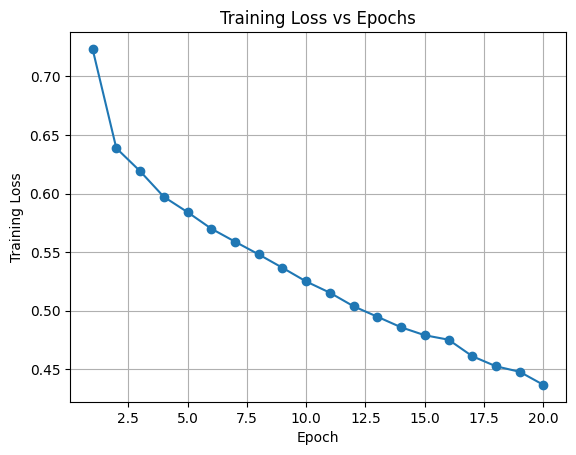

In [29]:
import matplotlib.pyplot as plt


train_losses = [
    0.7235, 0.6388, 0.6192, 0.5973, 0.5842,
    0.5701, 0.5590, 0.5481, 0.5367, 0.5250,
    0.5154, 0.5038, 0.4949, 0.4859, 0.4791,
    0.4753, 0.4612, 0.4526, 0.4479, 0.4367
]

epochs = list(range(1, len(train_losses) + 1))

plt.figure()
plt.plot(epochs, train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.show()

In [24]:
#calculating validation loss 
model.eval()
val_loss = 0.0

with torch.no_grad():
    for imgs, tumor_mask in val_loader:
        imgs = imgs.to(device)
        tumor_mask = tumor_mask.to(device)

        outputs = model(imgs)
        loss = loss_fn(outputs, tumor_mask)
        val_loss += loss.item()

val_loss /= len(val_loader)

print(f"Epoch [{epoch+1}] | Val Loss: {val_loss:.4f}")

e:\code\venvnew\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [20] | Val Loss: 0.4806


In [6]:
def dice_score(preds, targets, smooth=1e-6):
    """
    preds   : model outputs after sigmoid (B,1,H,W,D)
    targets : ground truth masks (B,1,H,W,D)
    """
    preds = (preds > 0.5).float()  # binarize

    intersection = (preds * targets).sum(dim=(2,3,4))
    union = preds.sum(dim=(2,3,4)) + targets.sum(dim=(2,3,4))

    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()


In [ ]:
model.eval()
dice_total = 0.0

with torch.no_grad():
    for imgs, tumor_mask in val_loader:
        imgs = imgs.to(device)
        tumor_mask = tumor_mask.to(device)

        outputs = model(imgs)
        outputs = torch.sigmoid(outputs)  # IMPORTANT

        dice = dice_score(outputs, tumor_mask)
        dice_total += dice.item()

mean_dice = dice_total / len(val_loader)
print(f"Validation Dice Score: {mean_dice:.4f}")

Validation Dice Score: 0.7465


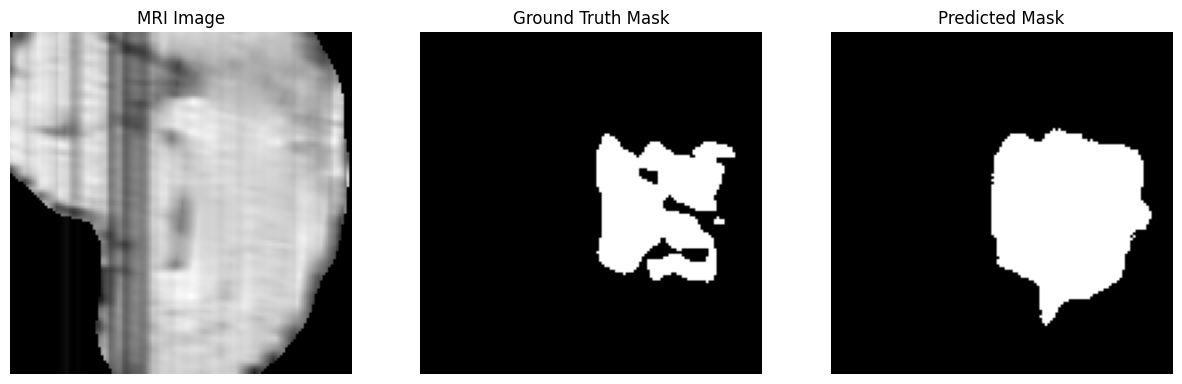

In [27]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    imgs, tumor_mask = next(iter(val_loader))
    imgs = imgs.to(device)
    tumor_mask = tumor_mask.to(device)

    outputs = model(imgs)
    outputs = torch.sigmoid(outputs)

# Move to CPU
img = imgs[0, 0].cpu().numpy()        # MRI (channel 0)
gt = tumor_mask[0, 0].cpu().numpy()   # GT mask
pred = (outputs[0, 0] > 0.5).cpu().numpy()  # Pred mask

# Choose middle slice
slice_idx = img.shape[0] // 2

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img[slice_idx], cmap="gray")
plt.title("MRI Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt[slice_idx], cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred[slice_idx], cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

In [30]:
#saving model
torch.save(model.state_dict(), "lg_unetr_brats.pth")

Hyperparameter tuning only Learning Rate

In [1]:
import torch
import torch.nn as nn
from monai.networks.nets import UNETR



e:\code\venvnew\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LGUNETR(nn.Module):
    def __init__(
        self,
        in_channels=4,
        out_channels=1,
        img_size=(128, 128, 128),
        feature_size=16,
        hidden_size=256,
        mlp_dim=1024,
        num_heads=8,
        dropout_rate=0.0
    ):
        super().__init__()

        self.unetr = UNETR(
            in_channels=in_channels,
            out_channels=out_channels,
            img_size=img_size,
            feature_size=feature_size,
            hidden_size=hidden_size,
            mlp_dim=mlp_dim,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            norm_name="instance",
            res_block=True,
        )

    def forward(self, x):
        return self.unetr(x)


In [14]:
learning_rates = [5e-5, 1e-5, 3e-4]
results_lr = []
num_epochs= 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
for lr in learning_rates:
    print(f"\n==============================")
    print(f"Training with Learning Rate = {lr}")
    print(f"==============================")

    # ---- fresh model for each LR ----
    model = LGUNETR(
        in_channels=4,
        out_channels=1,
        img_size=(128,128,128)
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=1e-5
    )

    loss_fn = BCEDiceLoss(bce_weight=0.5)

    # ---- training loop ----
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for imgs, tumor_mask in train_loader:
            imgs = imgs.to(device)
            tumor_mask = tumor_mask.to(device)

            optimizer.zero_grad()

            outputs = model(imgs)
            loss = loss_fn(outputs, tumor_mask)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        print(
            f"LR {lr} | Epoch [{epoch+1}/{num_epochs}] "
            f"| Train Loss: {train_loss:.4f}"
        )

    # ---- validation Dice (ONCE per LR) ----
    model.eval()
    dice_total = 0.0

    with torch.no_grad():
        for imgs, tumor_mask in val_loader:
            imgs = imgs.to(device)
            tumor_mask = tumor_mask.to(device)

            outputs = model(imgs)
            outputs = torch.sigmoid(outputs)

            preds = (outputs > 0.5).float()

            intersection = (preds * tumor_mask).sum()
            union = preds.sum() + tumor_mask.sum()

            dice = (2 * intersection + 1e-6) / (union + 1e-6)
            dice_total += dice.item()

    val_dice = dice_total / len(val_loader)
    results_lr.append((lr, val_dice))

    print(f" LR {lr} → Validation Dice: {val_dice:.4f}")



Training with Learning Rate = 5e-05


e:\code\venvnew\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LR 5e-05 | Epoch [1/5] | Train Loss: 0.6769
LR 5e-05 | Epoch [2/5] | Train Loss: 0.5773
LR 5e-05 | Epoch [3/5] | Train Loss: 0.5401
LR 5e-05 | Epoch [4/5] | Train Loss: 0.5213
LR 5e-05 | Epoch [5/5] | Train Loss: 0.5022
 LR 5e-05 → Validation Dice: 0.6046

Training with Learning Rate = 1e-05
LR 1e-05 | Epoch [1/5] | Train Loss: 0.7911
LR 1e-05 | Epoch [2/5] | Train Loss: 0.7344
LR 1e-05 | Epoch [3/5] | Train Loss: 0.6960
LR 1e-05 | Epoch [4/5] | Train Loss: 0.6607
LR 1e-05 | Epoch [5/5] | Train Loss: 0.6270
 LR 1e-05 → Validation Dice: 0.4464

Training with Learning Rate = 0.0003
LR 0.0003 | Epoch [1/5] | Train Loss: 0.6570
LR 0.0003 | Epoch [2/5] | Train Loss: 0.5710
LR 0.0003 | Epoch [3/5] | Train Loss: 0.5209
LR 0.0003 | Epoch [4/5] | Train Loss: 0.4759
LR 0.0003 | Epoch [5/5] | Train Loss: 0.4313
 LR 0.0003 → Validation Dice: 0.6358


Our initial dice was 0.74 and LR 0.0003 reached 0.63 in 5 epochs no now we will train it completely for 20 epochs and see whether it can overtake our initial model or not.

In [23]:
class LGUNETR(nn.Module):
    def __init__(
        self,
        in_channels=4,
        out_channels=1,
        img_size=(128, 128, 128),
        feature_size=16,
        hidden_size=256,
        mlp_dim=1024,
        num_heads=8,
        dropout_rate=0.0
    ):
        super().__init__()

        self.unetr = UNETR(
            in_channels=in_channels,
            out_channels=out_channels,
            img_size=img_size,
            feature_size=feature_size,
            hidden_size=hidden_size,
            mlp_dim=mlp_dim,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            norm_name="instance",
            res_block=True,
        )

    def forward(self, x):
        return self.unetr(x)


In [3]:
#testing the UNET-R baseline coded in the previous cell
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LGUNETR().to(device)

x = torch.randn(1, 4, 128, 128, 128).to(device)

with torch.no_grad():
    y = model(x)

print("Input shape :", x.shape)
print("Output shape:", y.shape)

Input shape : torch.Size([1, 4, 128, 128, 128])
Output shape: torch.Size([1, 1, 128, 128, 128])


In [4]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        """
        logits:  (B, 1, D, H, W)
        targets: (B, 1, D, H, W)
        """
        probs = torch.sigmoid(logits)

        probs = probs.view(-1)
        targets = targets.view(-1)

        intersection = (probs * targets).sum()
        dice = (2. * intersection + self.smooth) / (
            probs.sum() + targets.sum() + self.smooth
        )

        return 1 - dice

In [5]:
bce_loss = nn.BCEWithLogitsLoss()
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        dice_loss = self.dice(logits, targets)
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss

In [6]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0003,
    weight_decay=1e-5
)

In [28]:
num_epochs= 20

In [29]:
batch_size = 1  
lr = 0.0003
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for imgs, tumor_mask in train_loader:
        imgs = imgs.to(device)
        tumor_mask = tumor_mask.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = loss_fn(outputs, tumor_mask)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}")

e:\code\venvnew\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/20] | Train Loss: 0.5764
Epoch [2/20] | Train Loss: 0.4926
Epoch [3/20] | Train Loss: 0.4465
Epoch [4/20] | Train Loss: 0.4114
Epoch [5/20] | Train Loss: 0.3807
Epoch [6/20] | Train Loss: 0.3491
Epoch [7/20] | Train Loss: 0.3209
Epoch [8/20] | Train Loss: 0.3038
Epoch [9/20] | Train Loss: 0.2839
Epoch [10/20] | Train Loss: 0.2640
Epoch [11/20] | Train Loss: 0.2474
Epoch [12/20] | Train Loss: 0.2321
Epoch [13/20] | Train Loss: 0.2177
Epoch [14/20] | Train Loss: 0.2073
Epoch [15/20] | Train Loss: 0.1914
Epoch [16/20] | Train Loss: 0.2077
Epoch [17/20] | Train Loss: 0.1814
Epoch [18/20] | Train Loss: 0.1671
Epoch [19/20] | Train Loss: 0.1626
Epoch [20/20] | Train Loss: 0.1542


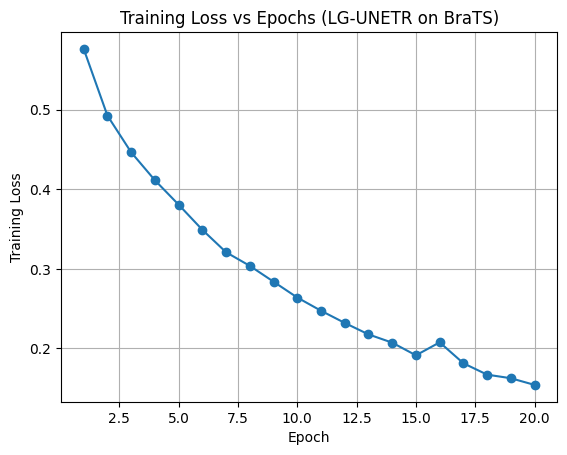

In [32]:
import matplotlib.pyplot as plt

# Training loss values (after hyperparameter tuning)
train_losses = [
    0.5764, 0.4926, 0.4465, 0.4114, 0.3807,
    0.3491, 0.3209, 0.3038, 0.2839, 0.2640,
    0.2474, 0.2321, 0.2177, 0.2073, 0.1914,
    0.2077, 0.1814, 0.1671, 0.1626, 0.1542
]

epochs = list(range(1, len(train_losses) + 1))

plt.figure()
plt.plot(epochs, train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs (LG-UNETR on BraTS)")
plt.grid(True)
plt.show()

In [30]:
#calculating validation loss 
model.eval()
val_loss = 0.0

with torch.no_grad():
    for imgs, tumor_mask in val_loader:
        imgs = imgs.to(device)
        tumor_mask = tumor_mask.to(device)

        outputs = model(imgs)
        loss = loss_fn(outputs, tumor_mask)
        val_loss += loss.item()

val_loss /= len(val_loader)

print(f"Epoch [{epoch+1}] | Val Loss: {val_loss:.4f}")

Epoch [20] | Val Loss: 0.1874


In [ ]:
def dice_score(preds, targets, smooth=1e-6):
    """
    preds   : model outputs after sigmoid (B,1,H,W,D)
    targets : ground truth masks (B,1,H,W,D)
    """
    preds = (preds > 0.5).float()  # binarize

    intersection = (preds * targets).sum(dim=(2,3,4))
    union = preds.sum(dim=(2,3,4)) + targets.sum(dim=(2,3,4))

    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()


model.eval()
dice_total = 0.0

with torch.no_grad():
    for imgs, tumor_mask in val_loader:
        imgs = imgs.to(device)
        tumor_mask = tumor_mask.to(device)

        outputs = model(imgs)
        outputs = torch.sigmoid(outputs)  # IMPORTANT

        dice = dice_score(outputs, tumor_mask)
        dice_total += dice.item()

mean_dice = dice_total / len(val_loader)
print(f"Validation Dice Score: {mean_dice:.4f}")  

Validation Dice Score: 0.8011


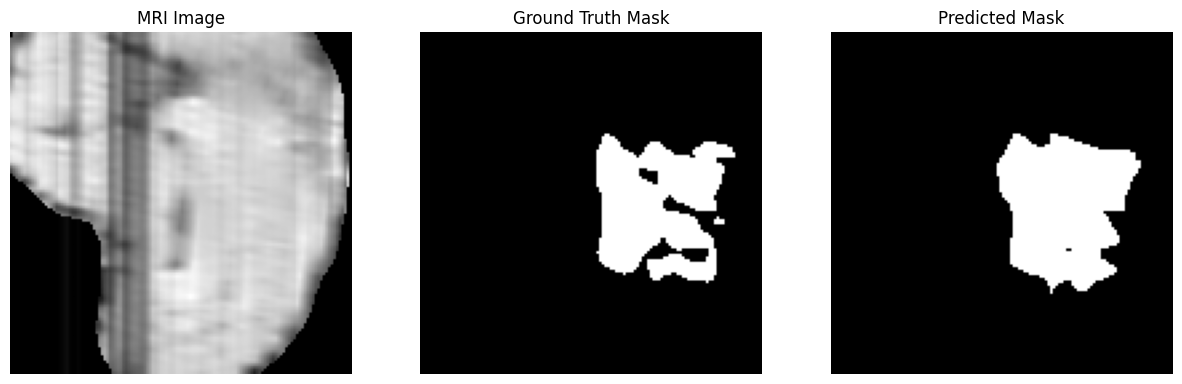

In [33]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    imgs, tumor_mask = next(iter(val_loader))
    imgs = imgs.to(device)
    tumor_mask = tumor_mask.to(device)

    outputs = model(imgs)
    outputs = torch.sigmoid(outputs)

# Move to CPU
img = imgs[0, 0].cpu().numpy()        # MRI (channel 0)
gt = tumor_mask[0, 0].cpu().numpy()   # GT mask
pred = (outputs[0, 0] > 0.5).cpu().numpy()  # Pred mask

# Choose middle slice
slice_idx = img.shape[0] // 2

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img[slice_idx], cmap="gray")
plt.title("MRI Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt[slice_idx], cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred[slice_idx], cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

In [34]:
#saving model after LR tuning
torch.save(model.state_dict(), "lg_unetr_brats_after_lr_tuning.pth")

Tuning BCEDiceLoss now as we have tuned learning rate previously

In [11]:
bce_weights = [0.2, 0.3, 0.5, 0.7]
results_bce = []

for bw in bce_weights:
    print("\n==============================")
    print(f"Training with BCE weight = {bw}")
    print("==============================")

    # fresh model
    model = LGUNETR(
        in_channels=4,
        out_channels=1,
        img_size=(128,128,128)
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.0003,              # FIXED best LR
        weight_decay=1e-5
    )

    loss_fn = BCEDiceLoss(bce_weight=bw)

    # short training
    for epoch in range(5):
        model.train()
        train_loss = 0.0

        for imgs, tumor_mask in train_loader:
            imgs = imgs.to(device)
            tumor_mask = tumor_mask.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, tumor_mask)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f"BCE {bw} | Epoch {epoch+1}/5 | Train Loss: {train_loss:.4f}")

    # validation Dice
    model.eval()
    dice_total = 0.0

    with torch.no_grad():
        for imgs, tumor_mask in val_loader:
            imgs = imgs.to(device)
            tumor_mask = tumor_mask.to(device)

            outputs = torch.sigmoid(model(imgs))
            preds = (outputs > 0.5).float()

            intersection = (preds * tumor_mask).sum()
            union = preds.sum() + tumor_mask.sum()
            dice = (2 * intersection + 1e-6) / (union + 1e-6)

            dice_total += dice.item()

    val_dice = dice_total / len(val_loader)
    results_bce.append((bw, val_dice))

    print(f" BCE weight {bw} → Validation Dice: {val_dice:.4f}")



Training with BCE weight = 0.2


e:\code\venvnew\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


BCE 0.2 | Epoch 1/5 | Train Loss: 0.7197
BCE 0.2 | Epoch 2/5 | Train Loss: 0.6683
BCE 0.2 | Epoch 3/5 | Train Loss: 0.6335
BCE 0.2 | Epoch 4/5 | Train Loss: 0.6031
BCE 0.2 | Epoch 5/5 | Train Loss: 0.5704
 BCE weight 0.2 → Validation Dice: 0.4897

Training with BCE weight = 0.3
BCE 0.3 | Epoch 1/5 | Train Loss: 0.6887
BCE 0.3 | Epoch 2/5 | Train Loss: 0.6223
BCE 0.3 | Epoch 3/5 | Train Loss: 0.5868
BCE 0.3 | Epoch 4/5 | Train Loss: 0.5559
BCE 0.3 | Epoch 5/5 | Train Loss: 0.5284
 BCE weight 0.3 → Validation Dice: 0.5810

Training with BCE weight = 0.5
BCE 0.5 | Epoch 1/5 | Train Loss: 0.5391
BCE 0.5 | Epoch 2/5 | Train Loss: 0.4473
BCE 0.5 | Epoch 3/5 | Train Loss: 0.3981
BCE 0.5 | Epoch 4/5 | Train Loss: 0.3573
BCE 0.5 | Epoch 5/5 | Train Loss: 0.3230
 BCE weight 0.5 → Validation Dice: 0.6765

Training with BCE weight = 0.7
BCE 0.7 | Epoch 1/5 | Train Loss: 0.4601
BCE 0.7 | Epoch 2/5 | Train Loss: 0.3746
BCE 0.7 | Epoch 3/5 | Train Loss: 0.3299
BCE 0.7 | Epoch 4/5 | Train Loss: 0.3041

Since BCE 0.7 proved to be very good in comparison to others so we are now proceeding with it and training model again

In [14]:
bce_loss = nn.BCEWithLogitsLoss()
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.7):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        dice_loss = self.dice(logits, targets)
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss

In [15]:
class LGUNETR(nn.Module):
    def __init__(
        self,
        in_channels=4,
        out_channels=1,
        img_size=(128, 128, 128),
        feature_size=16,
        hidden_size=256,
        mlp_dim=1024,
        num_heads=8,
        dropout_rate=0.0
    ):
        super().__init__()

        self.unetr = UNETR(
            in_channels=in_channels,
            out_channels=out_channels,
            img_size=img_size,
            feature_size=feature_size,
            hidden_size=hidden_size,
            mlp_dim=mlp_dim,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            norm_name="instance",
            res_block=True,
        )

    def forward(self, x):
        return self.unetr(x)


In [17]:
num_epochs=20
batch_size = 1  
lr = 0.0003
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for imgs, tumor_mask in train_loader:
        imgs = imgs.to(device)
        tumor_mask = tumor_mask.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = loss_fn(outputs, tumor_mask)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}")

e:\code\venvnew\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/20] | Train Loss: 0.2539
Epoch [2/20] | Train Loss: 0.2369
Epoch [3/20] | Train Loss: 0.2224
Epoch [4/20] | Train Loss: 0.2091
Epoch [5/20] | Train Loss: 0.1902
Epoch [6/20] | Train Loss: 0.1805
Epoch [7/20] | Train Loss: 0.1716
Epoch [8/20] | Train Loss: 0.1601
Epoch [9/20] | Train Loss: 0.1604
Epoch [10/20] | Train Loss: 0.1508
Epoch [11/20] | Train Loss: 0.1376
Epoch [12/20] | Train Loss: 0.1345
Epoch [13/20] | Train Loss: 0.1266
Epoch [14/20] | Train Loss: 0.1249
Epoch [15/20] | Train Loss: 0.1248
Epoch [16/20] | Train Loss: 0.1208
Epoch [17/20] | Train Loss: 0.1103
Epoch [18/20] | Train Loss: 0.1052
Epoch [19/20] | Train Loss: 0.1048
Epoch [20/20] | Train Loss: 0.1007


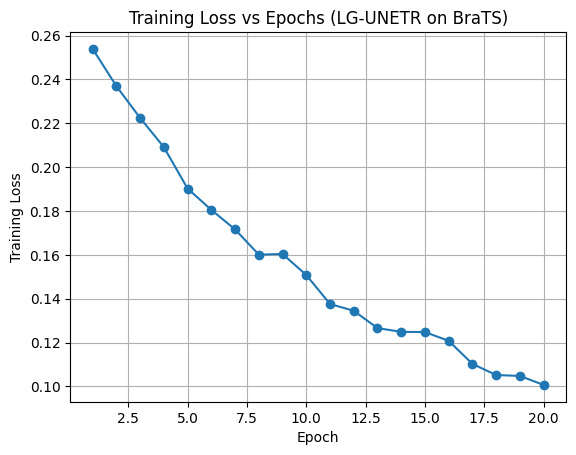

In [21]:
import matplotlib.pyplot as plt

# Training loss values (after hyperparameter tuning)
train_losses = [
0.2539,
0.2369,
0.2224,
0.2091,
0.1902,
0.1805,
0.1716,
0.1601,
0.1604,
0.1508,
0.1376,
0.1345,
0.1266,
0.1249,
0.1248,
0.1208,
0.1103,
0.1052,
0.1048,
0.1007
]

epochs = list(range(1, len(train_losses) + 1))

plt.figure()
plt.plot(epochs, train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs (LG-UNETR on BraTS)")
plt.grid(True)
plt.show()

In [18]:
#calculating validation loss 
model.eval()
val_loss = 0.0

with torch.no_grad():
    for imgs, tumor_mask in val_loader:
        imgs = imgs.to(device)
        tumor_mask = tumor_mask.to(device)

        outputs = model(imgs)
        loss = loss_fn(outputs, tumor_mask)
        val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}] | Val Loss: {val_loss:.4f}")

Epoch [20] | Val Loss: 0.1432


In [19]:
def dice_score(preds, targets, smooth=1e-6):
    """
    preds   : model outputs after sigmoid (B,1,H,W,D)
    targets : ground truth masks (B,1,H,W,D)
    """
    preds = (preds > 0.5).float()  # binarize

    intersection = (preds * targets).sum(dim=(2,3,4))
    union = preds.sum(dim=(2,3,4)) + targets.sum(dim=(2,3,4))

    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()


model.eval()
dice_total = 0.0

with torch.no_grad():
    for imgs, tumor_mask in val_loader:
        imgs = imgs.to(device)
        tumor_mask = tumor_mask.to(device)

        outputs = model(imgs)
        outputs = torch.sigmoid(outputs)  # IMPORTANT

        dice = dice_score(outputs, tumor_mask)
        dice_total += dice.item()

mean_dice = dice_total / len(val_loader)
print(f"Validation Dice Score: {mean_dice:.4f}")  

Validation Dice Score: 0.7678


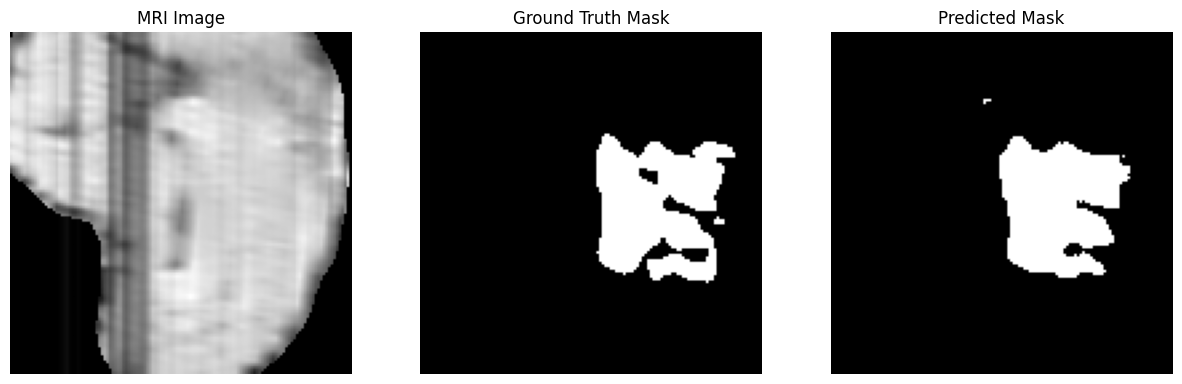

In [20]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    imgs, tumor_mask = next(iter(val_loader))
    imgs = imgs.to(device)
    tumor_mask = tumor_mask.to(device)

    outputs = model(imgs)
    outputs = torch.sigmoid(outputs)

# Move to CPU
img = imgs[0, 0].cpu().numpy()        # MRI (channel 0)
gt = tumor_mask[0, 0].cpu().numpy()   # GT mask
pred = (outputs[0, 0] > 0.5).cpu().numpy()  # Pred mask

# Choose middle slice
slice_idx = img.shape[0] // 2

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img[slice_idx], cmap="gray")
plt.title("MRI Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt[slice_idx], cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred[slice_idx], cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

Although loss at bce = 0.7 decreased but we will still proceed with bce = 0.5 because it had better dice score and in segmentation problems dice score matters to us more than loss. 

Now we are ready with our parameters that is learning rate and bce dice weight, therefore we are going to evaluate metrics on test dataset and apply our model to it.

In [24]:
model = LGUNETR(
    in_channels=4,
    out_channels=1,
    img_size=(128,128,128)
).to(device)

model.load_state_dict(torch.load("lg_unetr_brats_after_lr_tuning.pth"))
model.eval()

LGUNETR(
  (unetr): UNETR(
    (vit): ViT(
      (patch_embedding): PatchEmbeddingBlock(
        (patch_embeddings): Conv3d(4, 256, kernel_size=(16, 16, 16), stride=(16, 16, 16))
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (blocks): ModuleList(
        (0-11): 12 x TransformerBlock(
          (mlp): MLPBlock(
            (linear1): Linear(in_features=256, out_features=1024, bias=True)
            (linear2): Linear(in_features=1024, out_features=256, bias=True)
            (fn): GELU(approximate='none')
            (drop1): Dropout(p=0.0, inplace=False)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (attn): SABlock(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
            (qkv): Linear(in_features=256, out_features=768, bias=False)
            (to_q): Identity()
            (to_k): Identity()
            (to_v): Identity()
            (inp

In [25]:
model.eval()
dice_total = 0.0

with torch.no_grad():
    for imgs, tumor_mask in test_loader:
        imgs = imgs.to(device)
        tumor_mask = tumor_mask.to(device)

        outputs = model(imgs)
        outputs = torch.sigmoid(outputs)

        dice = dice_score(outputs, tumor_mask)
        dice_total += dice.item()

mean_test_dice = dice_total / len(test_loader)
print(f"Test Dice Score: {mean_test_dice:.4f}")

e:\code\venvnew\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Dice Score: 0.8130


Following test was performed to check that if model doesnt predicts tumor anywhere what dice do I get. For a correct pipeline it should be close to 0 and thats what we have got.

In [ ]:
# Test : Dice between GT mask and ALL-ZERO prediction
dice_total = 0.0

with torch.no_grad():
    for imgs, tumor_mask in test_loader:
        tumor_mask = tumor_mask.to(device)
        preds = torch.zeros_like(tumor_mask)  # predict all background
        dice = dice_score(preds, tumor_mask)
        dice_total += dice.item()

print("Dice for all-zero prediction:", dice_total / len(test_loader))


Dice for all-zero prediction: 7.48781380263994e-12


Documenting results :-

Our Validation and Test dice score are 0.8011 and 0.8130 that means model has generalized well.
We used lg_unetr_brats_after_lr_tuning.pth as it was the best performing model with learning rate of 0.0003 and bce dice weight as 0.5.

The pipeline has succesfully implemented a generalized method to perform segmentation of tumor in a binary way.
